# Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru

**Описание проекта**
<br>Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете,
<br>желаемой стоимости, возрасте ученика, целью занятий и тд.
<br>К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
<br>Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок —
<br>тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

**Цель:**
- Сократить загрузку отдела консультантов на 30%
- Увеличить конверсию в оплату на 15 п.п. через сегментацию заявок по вероятности их оплаты

**Задачи:**
<br>Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом.
<br>Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет.
<br>Оценка качества модели будет производиться с использованием `precision` и `ROC-AUC`.

**Целевые метрики (пожелания от заказчика)**
- 50-75% от общего объёма заявок можно будет не обрабатывать, так как они не будут оплачены
- обозначение топ 5-25% заявок, которым нужно отдать максимальный приоритет
- допускается, что модель будет показывать больше заявок как хороших, чем на самом деле (ошибка precision оплаченных заявок)
- не допускается, что модель относит потенциально оплаченные заявки к плохим заявкам (низкая precision неоплаченных заявок)

Данные для 0 (неоплачено) и 1 (оплачено) классов.
<br>`recall`, например, для оплаченных заявок показывает процент предсказанных как оплаченные от всех истинно оплаченных заявок. <br>`f1-score` это некий баланс между `precision` и `recall`.
<br>А `support` - кол-во наблюдений отнесенных к тому или иному классу.

|class|precision|recall|f1-score|support|
|--:|--:|--:|--:|--:|
|0|0.89|1.00|0.94|187629|
|1|0.50|0.02|0.04|24097|

**Ход исследования:**
- загрузка данных и ознакомление с ними,
- отбор подходящих признаков,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- создание сервиса в виде Docker Container,
- отчёт по проведённому исследованию.

**Описание данных**
- Заявки (orders*.csv)
  - order_date - дата создания
  - subject_id - предмет
  - purpose - цель занятий
  - lesson_price - цена
  - lesson_duration - желаемая проодолжительность урока
  - home_metro_id - ближайшее метро
  - add_info - доп инфо
  - start_date
  - working_teacher_id
  - status_id - оплачена ли заявка (значения 6 и 13 - факт оплаты заявки, значения 5 и 15 - частичная оплата)
  - comments   
  - amount_to_pay
  - planned_lesson_number - клиент планирует N занятий
  - first_lesson_date - дата 1 занятия
  - coef - коэффициент
  - creator_id - кто создал заявку (id сотрудника или клиента)
  - pupil_category_new_id - возраст ученика
  - lessons_per_week - занятий а неделю
  - minimal_price
  - teacher_sex - пол репетитора
  - teacher_experience_from - опыт репетитора от
  - teacher_experience_to- опыт репетитора до
  - lesson_place_new - онлайн, у ученика, у учителя
  - pupil_knowledgelvl -уровень знаний ученика
  - teacher_age_from - желаемый возраст репеитора от
  - teacher_age_to - желаемый возраст репеитора от
  - chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
  - no_teachers_available - на заявку нет подходящих репов
  - source_id - где создана заявка (какая часть сайта, не регион)
  - original_order_id - дублем какой заявки является эта заявка
  - client_id - айди клиента
  - additional_status_id
  - max_metro_distance - максимально готов ехать от метро
  - estimated_fee
  - payment_date
  - test_group - аб тесты
  - is_display_to_teachers - хочет ли клиент получать отклики репетиторов

- Репетиторы (teacher_info.csv)
  - date_update
  - reg_date
  - birth_date
  - teaching_start_date
  - user_id - айди
  - is_email_confirmed
  - is_home_lessons
  - is_external_lessons
  - external_comments
  - lesson_duration - продолжит урока
  - lesson_cost - стоимость урока
  - status_id
  - status_relevant_date
  - status_school_id
  - status_college_id
  - status_display
  - russian_level_id
  - home_country_id
  - education
  - information
  - is_confirmed
  - is_display - показывается в каталоге
  - rating_id
  - rating - рейтинг
  - comments
  - rules_confirmed_date
  - last_visited - послеждний визит
  - is_pupils_needed - открыт для заявок
  - is_cell_phone_confirmed
  - effective_rating - какой-то еще рейтинг
  - area_id
  - registrar_id
  - pupil_needed_date
  - sex
  - amount_to_pay - долг
  - is_remote_lessons
  - remote_comments
  - show_on_map
  - send_mailing
  - send_suitable_orders
  - rating_for_users - рейтинг 2
  - rating_for_admin - рейтинг 3
  - passport_id
  - is_edited
  - orders_allowed - разрешено назначать на заявки
  - display_days
  - verification_status_id
  - is_individual
  - partner_id
  - star_rating - рейтинг 4
  - rating_for_users_yesterday - рейтинг вчера
  - review_num - отзывы
  - relevance_date
  - is_display_at_partners
  - video_presentation_id - есть видеопрезентация
  - status_institution_id
  - Free_time_relevance_date


- Подходящие по фильтру репетиторы (suitable_teachers.csv)
  - tteacher_id - id репетитора
  - order_id - id заявки
  - contact_result    
  - enable_auto_assign - доступен ли репетитор к работе или заблокирован
    <br>(может ли репетитора назначить консультант и может ли он сам назначиться)
    <br>(значение известно на момент подачи заявки)
  - enable_assign - доступен ли репетитор к работе или заблокирован
    <br>(может ли репетитора назначить консультант и может ли он сам назначиться)
    <br>(значение известно на момент подачи заявки)


- Желаемые репетиторы (prefered_teachers_order_id.csv)
  <br>Репетиторы, которых выбрал клиент.
  - tteacher_id - id репетитора
  - order_id - id заявки

## Настройка рабочей среды

In [ ]:
!pip install shap
!pip install phik
!pip install catboost
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import shap
import phik
import torch
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import (
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_score,
    confusion_matrix
    )
from catboost import CatBoostClassifier, Pool
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

warnings.filterwarnings("ignore", category=UserWarning)

Монтирование диска (Google Colab)

In [ ]:
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подключение к GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Установка констант

In [ ]:
RANDOM_STATE = 42
CHUNKSIZE = 10000

Установка `random_state`

In [ ]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Загрузка данных

In [ ]:
try:
  orders = pd.read_feather('data/orders.feather')
  teachers_info = pd.read_feather('data/teachers_info.feather')
  suitable_teachers = pd.read_feather('data/suitable_teachers.feather')
  prefered_teachers_order_id = pd.read_feather('data/prefered_teachers_order_id.feather')
  print('загружено из каталога "data"')
except:
  orders = pd.read_feather(userdata.get('orders_path'))
  teachers_info = pd.read_feather(userdata.get('teachers_info'))
  suitable_teachers = pd.read_feather(userdata.get('suitable_teachers'))
  prefered_teachers_order_id = pd.read_feather(userdata.get('preferred_teachers_order_id'))
  print('загружено из каталога Google Drive')

загружено из каталога Google Drive


### Заявки

In [ ]:
orders.info()
orders.sample()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
40101,1881671,2021-12-06 17:01:13.553,13.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,500,60,None,2276.0,Район: г. Каспийск.\nМесто проведения занятий:...,None,...,0,1,16,NaN,878030,8.0,NaN,None,None,1


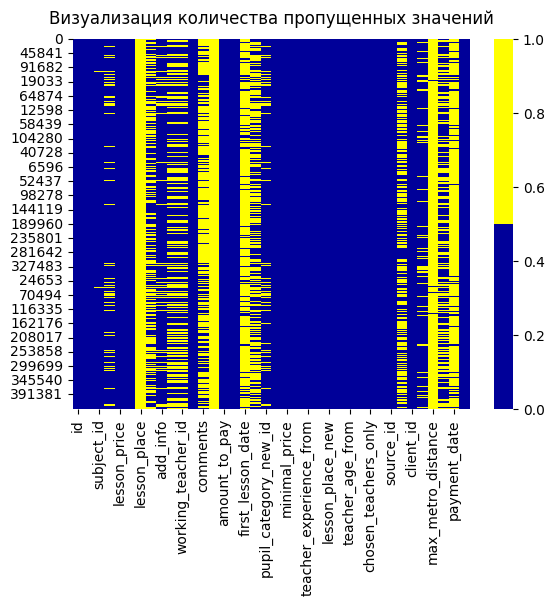

In [ ]:
sns.heatmap(orders.isnull(), cmap=sns.color_palette(['#000099', '#ffff00']))
plt.xticks(rotation=90)
plt.title('Визуализация количества пропущенных значений', size=12, y=1.02)
plt.show()

In [ ]:
print(f"количество полных дубликатов строк: {orders.duplicated().sum()}")
print(f"""количество полных дубликатов в общем количестве строк:
{orders.duplicated().sum() / orders.shape[0] * 100:.3f}%""")

количество полных дубликатов строк: 900
количество полных дубликатов в общем количестве строк:
0.076%


Удаление обнаруженных повторов строк

In [ ]:
orders.drop_duplicates(inplace=True)
orders.reset_index(drop=True, inplace=True)

In [ ]:
print(f"""уникальные значения status_id:
{orders['status_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения status_id:
3605505         1
3342337         1
3211265         1
16         791756
15           3469
14          32933
13           2111
12           4731
11           7202
9            1057
8            8178
7          212694
6          121413
5             291
4            1852
3            3166
2               3
1             102
Name: status_id, dtype: int64


Удаление строк с некорректным значением status_id

In [ ]:
orders = orders.drop(orders[orders['status_id'] > 16].index)

Создание целевого признака

In [ ]:
orders['fact_of_payment'] = (orders['status_id'].isin([6, 13, 5, 15])).astype('int8')

Изменение типов данных

In [ ]:
orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']] = (
    orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']]
    .apply(pd.to_datetime)
    )

Создание признака `order_month`

In [ ]:
orders['order_month'] = orders['order_date'].dt.month.astype('int8')

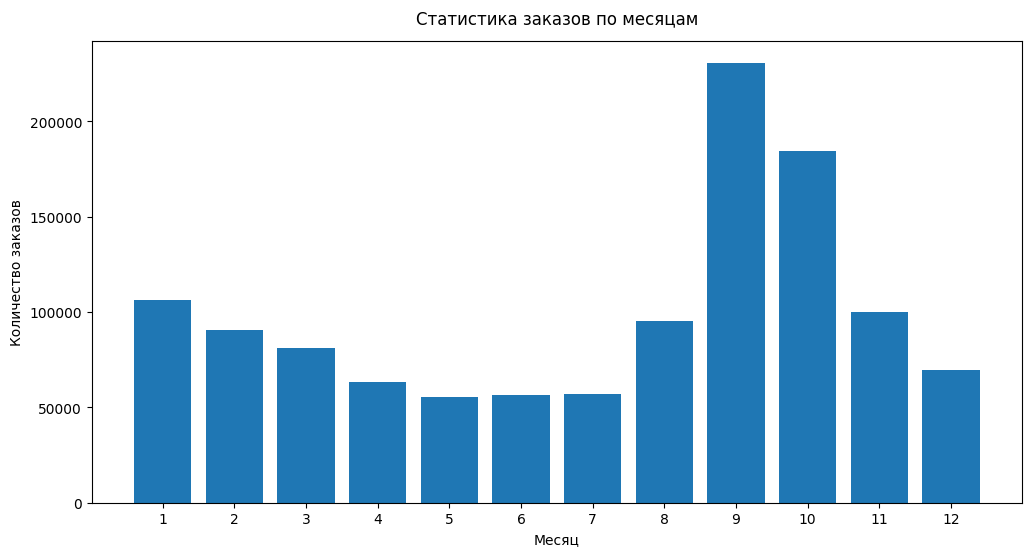

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(orders['order_month'].value_counts().sort_index(ascending=True).index.tolist(),
        orders['order_month'].value_counts().sort_index(ascending=True).tolist())

plt.xlabel('Месяц')
plt.xticks(orders['order_month'].value_counts().sort_index(ascending=True).index.tolist())
plt.ylabel('Количество заказов')
plt.title('Статистика заказов по месяцам', fontsize=12, y=1.02)
plt.show()

In [ ]:
print(f"""уникальные значения subject_id:
{orders['subject_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения subject_id:
36.0      5625
33.0     33318
29.0     12622
27.0     12281
25.0      4909
23.0      7281
21.0     24767
20.0     16651
19.0     46684
18.0     64282
17.0      7853
16.0      8171
15.0     11367
14.0     36796
13.0     20048
12.0     42127
11.0     59734
10.0     57223
9.0      58706
8.0     311066
7.0      16147
6.0       8682
5.0       4456
4.0      12595
3.0      17515
2.0     170675
1.0     109052
Name: subject_id, dtype: int64


Удаление строк с некорректным значением subject_id

In [ ]:
orders = orders.drop(orders[orders['subject_id'] > 36].index)

Заполнение пропусков в subject_id

In [ ]:
'''
пропущенные значения означают, что поле с предметом не заполнено.
на мой взгляд, их логично заполнить нулями.
'''
orders['subject_id'] = orders['subject_id'].fillna(0)

In [ ]:
orders['teacher_sex'] = orders['teacher_sex'].astype('int8')
print(f"""уникальные значения teacher_sex:
{orders['teacher_sex'].value_counts().sort_index(ascending=False)}""")

уникальные значения teacher_sex:
3    549412
2    391981
1     46011
0    203554
Name: teacher_sex, dtype: int64


In [ ]:
print(f"примеры записей в колонке purpose:\n{orders['purpose'].unique()[:10]}")

примеры записей в колонке purpose:
[None
 'Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь по программе.'
 'Разделы:  школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.'
 'Разделы: ораторское искусство.\nКатегория ученика: студент 2 курса.\nЦель занятий: для себя.'
 'Разделы:  школьный курс.\nКатегория ученика: школьник 8 класса.\nЦель занятий:  улучшить успеваемость.'
 'Разделы: теоретическая механика.\nКатегория ученика: студент 2 курса.\nЦель занятий: помощь по предмету.'
 'Разделы:  школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 10 класса.\nЦель занятий: подготовить к ЕГЭ, профиль.'
 'Разделы:  школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: подтянуть по школьной программе, повысить успеваемость.'
 'Разделы: общий курс.\nКатегория ученика: студентка 7 курса, магистратуры.\nУровень знаний: средний (В1).\nЦель занятий: подготовка к поступлению в аспирант

Заполнение пропусков колонки `purpose`

In [ ]:
# Заполнение пропущенных значений
orders['purpose'] = orders['purpose'].fillna('data not entered')

In [ ]:
print(f"""уникальные значения pupil_knowledgelvl:
{orders['pupil_knowledgelvl'].value_counts().sort_index(ascending=False)}""")

уникальные значения pupil_knowledgelvl:
4      6726
3     46817
2    105377
1     85325
0    946713
Name: pupil_knowledgelvl, dtype: int64


In [ ]:
print(f"""количество уникальных значений lesson_price:
{orders['lesson_price'].nunique()}""")

print(f"""количество уникальных значений minimal_price:
{orders['minimal_price'].nunique()}""")

количество уникальных значений lesson_price:
346
количество уникальных значений minimal_price:
168


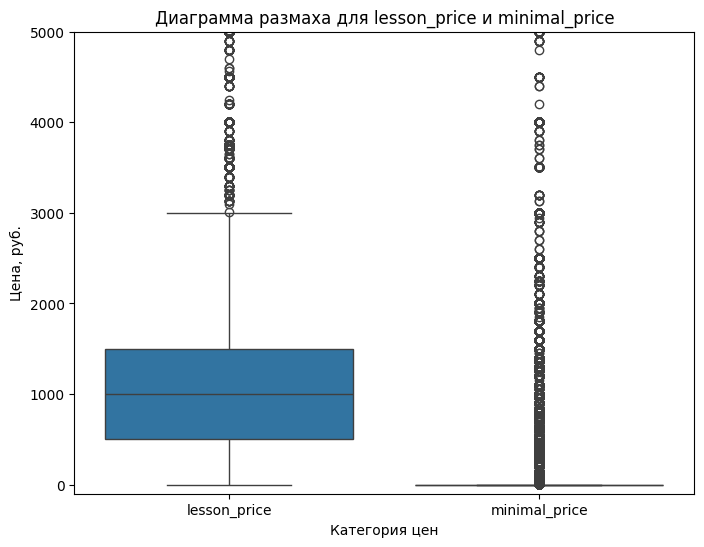

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=orders[['lesson_price', 'minimal_price']])
plt.ylim(-100, 5000)
plt.title('Диаграмма размаха для lesson_price и minimal_price', size=12)
plt.ylabel('Цена, руб.')
plt.xlabel('Категория цен')
plt.show()

Добавление признака с категорией цены

In [ ]:
orders['lesson_price_cat'] = (orders['lesson_price']
                              .apply(lambda x: 1 if x < 500
                                     else 2 if 500 <= x < 1500
                                     else 3 if 1500 <= x <= 3000
                                     else 4)
                              .astype('int8')
                             )

In [ ]:
print(f"""уникальные значения lesson_duration:
{orders['lesson_duration'].value_counts().sort_index(ascending=False)}""")

уникальные значения lesson_duration:
135        192
120       7210
90       25634
60     1135634
45       19902
0         2386
Name: lesson_duration, dtype: int64


In [ ]:
print(f"""количество уникальных значений home_metro_id:
{orders['home_metro_id'].nunique()}""")

количество уникальных значений home_metro_id:
2323


In [ ]:
'''
заполню пропуски в признаке home_metro_id значением '-1'
'''
orders['home_metro_id'] = orders['home_metro_id'].fillna(-1)

In [ ]:
print(f"примеры записей в колонке add_info:\n{orders['add_info'].unique()[:10]}")

примеры записей в колонке add_info:
[None
 'Место проведения занятий: дистанционно (например, Skype). Время МСК.\nПредполагаемое число занятий в неделю: 1, будни и суббота после 17, воскресенье в течение дня.'
 'Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, вторник, четверг с 17, суббота с 14.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: от 20 лет до 90 лет.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподаватель.'
 'Место проведения занятий: дистанционно (например, Skype) +3 МСК\nПредполагаемое число занятий в неделю: 2-3 (будни после 18 часов +3 МСК).\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.'
 'Район: м. Перово.\nМесто проведения занятий: у ученика (ул Кусковская ).\nПредполагаемое число занятий в неделю: 1 Воскресенье - в любое время.\nОпыт репетитора: не имеет значения.\nВозраст репетитора:

In [ ]:
print(f"примеры записей в колонке comments:\n{orders['comments'].unique()[:10]}")

примеры записей в колонке comments:
[None
 '\n01.11.2022 11:46 - "Заявка прикреплена к заявке № 2294000" (Алешина Марина)'
 'Тестовая группа : SplitTestA' 'Тестовая группа : SplitTestB'
 'Тестовая группа : SplitTestB\n01.11.2022 09:07 - "Заявка прикреплена к заявке № 2294059" (Столярова Алена)'
 '\n01.11.2022 09:14 - "Заявка прикреплена к заявке № 2294052" (Дрешпан Екатерина)'
 'Тестовая группа : SplitTestB\n01.11.2022 09:09 - "Заявка прикреплена к заявке № 2293937" (Мищенко Ирина)'
 'Тестовая группа : SplitTestB\n01.11.2022 09:06 - "Заявка прикреплена к заявке № 2293937" (Мищенко Ирина)'
 'Тестовая группа : SplitTestB\n?Статус дозаполнения : начато заполнение клиентом?\n?Статус дозаполнения : Заполнена клиентом?'
 'Тестовая группа : SplitTestA\n01.11.2022 09:25 - "Заявка прикреплена к заявке № 2294084" (Солоненко Анна)']


In [ ]:
orders['planned_lesson_number'] = orders['planned_lesson_number'].astype('int8')
print(f"""уникальные значения planned_lesson_number:
{orders['planned_lesson_number'].value_counts().sort_index(ascending=False)}""")

уникальные значения planned_lesson_number:
10    937986
7      68302
2      11622
1       6579
0     166469
Name: planned_lesson_number, dtype: int64


In [ ]:
print(f"""уникальные значения pupil_category_new_id:
{orders['pupil_category_new_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения pupil_category_new_id:
17.0      5072
16.0     12334
15.0    113746
14.0     97127
12.0    140854
11.0     90061
10.0    171374
9.0      85297
8.0      71155
7.0      55446
6.0      47290
5.0      38133
4.0      33680
3.0      32648
2.0      18269
1.0      19166
Name: pupil_category_new_id, dtype: int64


Заполнение пропусков в категориях учеников

In [ ]:
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].fillna(-1)
orders['pupil_category_new_id'] = orders['pupil_category_new_id'].astype('int8')

уникальные значения lessons_per_week:
7     15086
6     28205
5    156359
4    236320
3    433602
2    142393
1      3870
0    175123
Name: lessons_per_week, dtype: int64


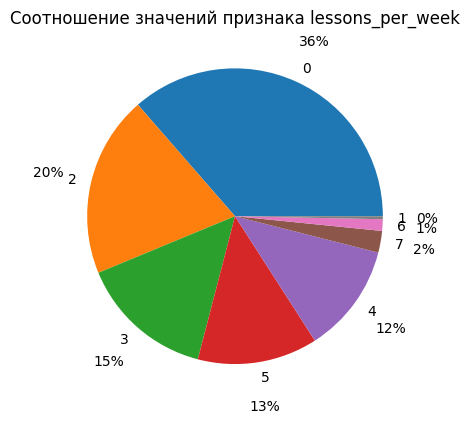

In [ ]:
orders['lessons_per_week'] = orders['lessons_per_week'].astype('int8')
print(f"""уникальные значения lessons_per_week:
{orders['lessons_per_week'].value_counts().sort_index(ascending=False)}""")

fig1, ax1 = plt.subplots()
ax1.pie(orders['lessons_per_week'].value_counts(),
        labels=orders['lessons_per_week'].unique(),
        autopct='%1.0f%%',
        pctdistance=1.3)
plt.title('Соотношение значений признака lessons_per_week', size=12)
plt.show()

In [ ]:
orders['teacher_experience_from'] = orders['teacher_experience_from'].astype('int8')
print(f"""описание teacher_experience_from:
{orders['teacher_experience_from'].describe()}""")
print(f"""количество уникальных значений teacher_experience_from:
{orders['teacher_experience_from'].nunique()}""")

orders['teacher_experience_to'] = orders['teacher_experience_to'].astype('int8')
print(f"""описание teacher_experience_to:
{orders['teacher_experience_to'].describe()}""")
print(f"""количество уникальных значений teacher_experience_to:
{orders['teacher_experience_to'].nunique()}""")

описание teacher_experience_from:
count    1.190958e+06
mean     1.468021e+00
std      2.784489e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.100000e+01
Name: teacher_experience_from, dtype: float64
количество уникальных значений teacher_experience_from:
40
описание teacher_experience_to:
count    1.190958e+06
mean     8.934370e-01
std      8.363181e+00
min     -1.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+02
Name: teacher_experience_to, dtype: float64
количество уникальных значений teacher_experience_to:
65


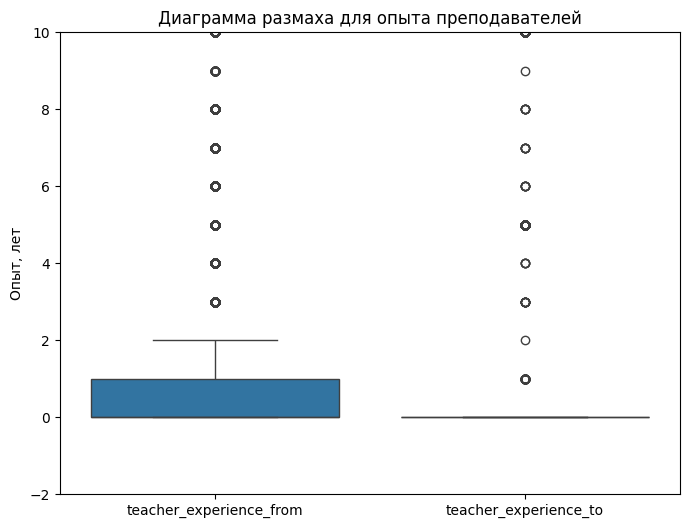

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=orders[['teacher_experience_from', 'teacher_experience_to']])
plt.ylim(-2, 10)
plt.title('Диаграмма размаха для опыта преподавателей', size=12)
plt.ylabel('Опыт, лет')
plt.show()

In [ ]:
orders['teacher_age_from'] = orders['teacher_age_from'].astype('int8')
print(f"""описание teacher_age_from:
{orders['teacher_age_from'].describe()}""")
print(f"""количество уникальных значений teacher_age_from:
{orders['teacher_age_from'].nunique()}""")

orders['teacher_age_to'] = orders['teacher_age_to'].astype('int8')
print(f"""описание teacher_age_to:
{orders['teacher_age_to'].describe()}""")
print(f"""количество уникальных значений teacher_age_to:
{orders['teacher_age_to'].nunique()}""")

описание teacher_age_from:
count    1.190958e+06
mean     8.310444e+00
std      1.194470e+01
min     -1.060000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+01
max      1.240000e+02
Name: teacher_age_from, dtype: float64
количество уникальных значений teacher_age_from:
83
описание teacher_age_to:
count    1.190958e+06
mean     1.726077e+01
std      2.795894e+01
min     -1.280000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+01
max      1.120000e+02
Name: teacher_age_to, dtype: float64
количество уникальных значений teacher_age_to:
104


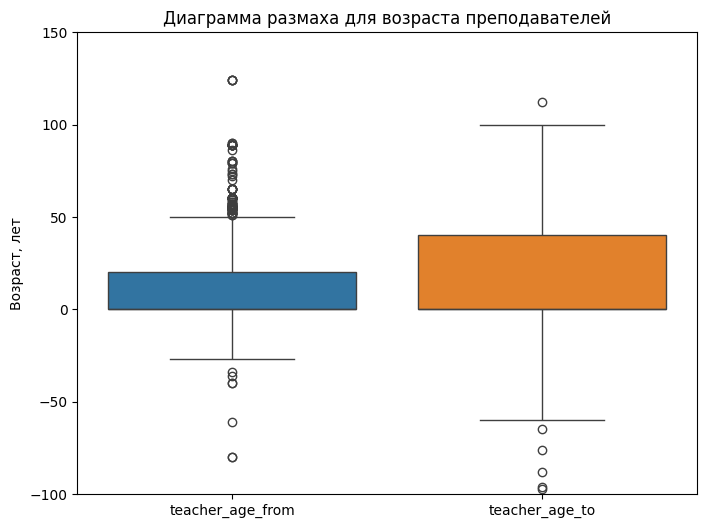

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=orders[['teacher_age_from', 'teacher_age_to']])
plt.ylim(-100, 150)
plt.title('Диаграмма размаха для возраста преподавателей', size=12)
plt.ylabel('Возраст, лет')
plt.show()

уникальные значения chosen_teachers_only:
1      26636
0    1164322
Name: chosen_teachers_only, dtype: int64


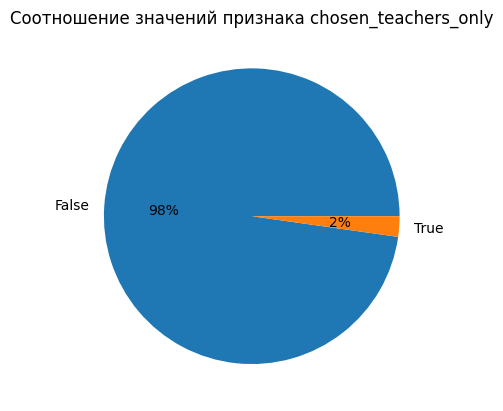

In [ ]:
print(f"""уникальные значения chosen_teachers_only:
{orders['chosen_teachers_only'].value_counts().sort_index(ascending=False)}""")

labels = 'False', 'True'
sizes = [orders['chosen_teachers_only'].value_counts()[0],
         orders['chosen_teachers_only'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение значений признака chosen_teachers_only', size=12)
plt.show()

уникальные значения no_teachers_available:
1     108205
0    1082753
Name: no_teachers_available, dtype: int64


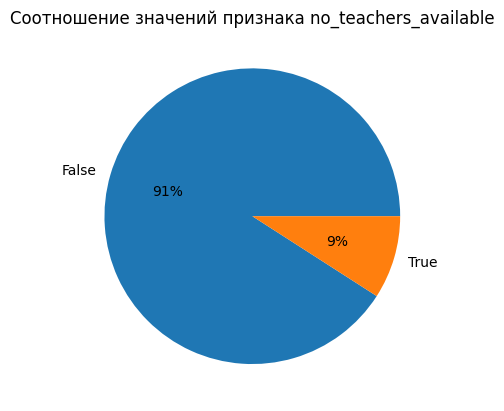

In [ ]:
print(f"""уникальные значения no_teachers_available:
{orders['no_teachers_available'].value_counts().sort_index(ascending=False)}""")

labels = 'False', 'True'
sizes = [orders['no_teachers_available'].value_counts()[0],
         orders['no_teachers_available'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение значений признака no_teachers_available', size=12)
plt.show()

In [ ]:
orders['source_id'] = orders['source_id'].astype('int8')
print(f"""уникальные значения source_id:
{orders['source_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения source_id:
26        38
25      2456
24     15864
23    441917
22      7813
20        10
18     10021
17      8900
16    279897
14    334229
13      1254
12       277
11        17
9      14617
8      49632
7        736
6       1037
5       3766
4       9829
3        187
2       7934
0        527
Name: source_id, dtype: int64


In [ ]:
print(f"""количество уникальных значений original_order_id:
{orders['original_order_id'].nunique()}""")

количество уникальных значений original_order_id:
314928


In [ ]:
# Создание групп по original_order_id
# orders['order_group'] = orders['original_order_id'].fillna(orders['id'])
orders.loc[orders['original_order_id'].isnull(), 'order_group'] = orders['id']

# Проверка и заполнение поля fact_of_payment для групп
orders['fact_of_payment'] = (orders
                             .groupby('order_group')['fact_of_payment']
                             .transform(lambda x: 1 if x.any() else x))

# Удаление дубликатов заявок
# orders = orders[orders['original_order_id'].isnull()]
orders = orders.loc[orders['original_order_id'].isnull()]

# Удаление временного столбца group
orders.drop('order_group', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(f"текущая размерность таблицы: {orders.shape}")
print(f"текущее количество уникальных номеров заявок: {orders['id'].nunique()}")

текущая размерность таблицы: (608721, 41)
текущее количество уникальных номеров заявок: 608721


Создание копии датафрейма без лишних признаков

In [ ]:
orders_processed = orders.copy()
orders_processed = orders_processed.drop(['order_date',
                                          'lesson_price',
                                          'lesson_place',  # данный признак не известен на момент подачи заявки
                                          'add_info',
                                          'start_date',  # данный признак не известен на момент подачи заявки
                                          'status_id',
                                          'comments',  # данный признак не известен на момент подачи заявки
                                          'prefered_teacher_id',  # данный признак не известен на момент подачи заявки
                                          'first_lesson_date',  # данный признак не известен на момент подачи заявки
                                          'creator_id',
                                          'teacher_age_from',
                                          'teacher_age_to',
                                          'original_order_id',
                                          'client_id',
                                          'additional_status_id',
                                          'max_metro_distance',
                                          'estimated_fee',  # данный признак не известен на момент подачи заявки
                                          'payment_date',  # данный признак не известен на момент подачи заявки
                                          'is_display_to_teachers',
                                          'additional_status_id',  # данный признак не известен на момент подачи заявки
                                          'working_teacher_id',  # данный признак не известен на момент подачи заявки
                                          'amount_to_pay'],  # данный признак не известен на момент подачи заявки
                                         axis=1)

In [ ]:
orders_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608721 entries, 2 to 1190958
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       608721 non-null  int32  
 1   subject_id               608721 non-null  float32
 2   purpose                  608721 non-null  object 
 3   lesson_duration          608721 non-null  int32  
 4   home_metro_id            608721 non-null  float32
 5   planned_lesson_number    608721 non-null  int8   
 6   pupil_category_new_id    608721 non-null  int8   
 7   lessons_per_week         608721 non-null  int8   
 8   minimal_price            608721 non-null  int32  
 9   teacher_sex              608721 non-null  int8   
 10  teacher_experience_from  608721 non-null  int8   
 11  teacher_experience_to    608721 non-null  int8   
 12  lesson_place_new         608721 non-null  int32  
 13  pupil_knowledgelvl       608721 non-null  int32  
 14  cho

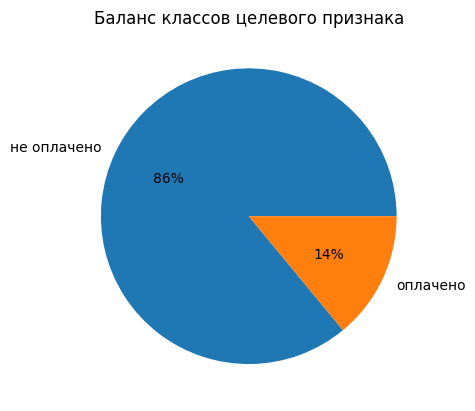

In [ ]:
labels = 'не оплачено', 'оплачено'
sizes = [orders_processed['fact_of_payment'].value_counts()[0],
         orders_processed['fact_of_payment'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Баланс классов целевого признака', size=12)
plt.show()

Анализ корреляционных связей между отобранными признаками

interval columns not set, guessing: ['subject_id', 'lesson_duration', 'home_metro_id', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'source_id', 'fact_of_payment', 'order_month', 'lesson_price_cat']


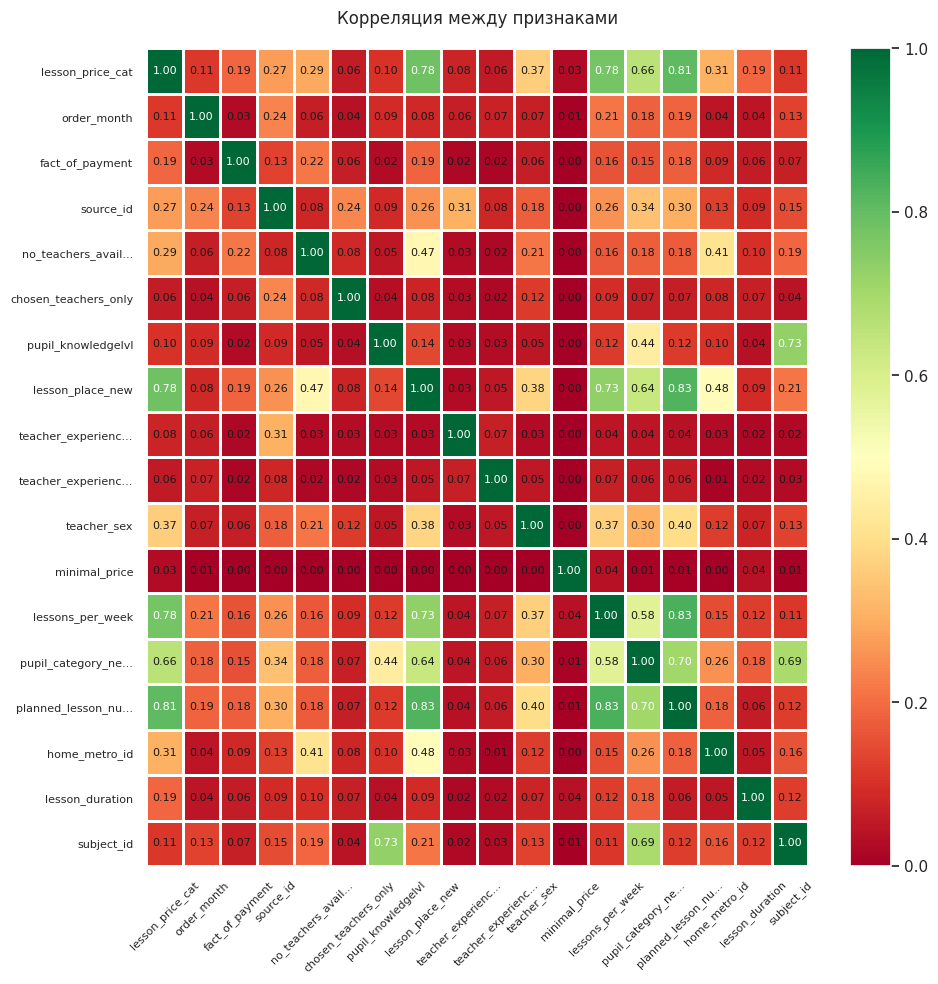

In [ ]:
phik_overview = orders_processed.drop(columns=['id',
                                               'purpose']).phik_matrix()

sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=0.8, figsize=(10, 10))
plt.xticks(rotation=45)
plt.title('Корреляция между признаками', fontsize=12, y=1.02)
plt.tight_layout()

In [ ]:
print(f"остаток данных от начального размера: {orders_processed.shape[0] / 1191861 * 100:.0f}%")

остаток данных от начального размера: 51%


#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.076% от общего количества данных);
- принято решение об удалении найденных повторов ввиду их малочисленности;
- удалены три строки с некорректными значениями признака `status_id`;
- создан целевой признак `fact_of_payment`;
- даты преобразованы в корректный формат;
- из даты `order_date` создан признак `order_month`;
- наиболее загруженный заказами месяц - сентябрь, наименее загруженные - май, июнь и июль;
- удалены четыре строки с некорректными значениями признака `subject_id`;
- пропуски в признаке `subject_id` (10325 штук) заполнены нулями;
- в признаке `teacher_sex` четыре уникальных значения. По данным от Заказчика: 1 - М, 2 - Ж;
- в колонке `purpose` заполнены пропущенные значения. При необходимости её можно будет разделить на дополнительные признаки: `pupil_section`, `pupil_additions`, `pupil_category`, `pupil_knlvl`, `pupil_goal`. Либо - закодировать, как единый признак через text features. Либо получить эмбеддинги и работать с ними;
- в признаках `lesson_price` и `minimal_price` большое количество выбросов, возможно, данные вносились не совсем корректно;
- введён новый признак с категориями стоимости уроков `lesson_price_cat`;
- желаемая продолжительность занятия варьируется от 0 до 135-ти минут (категориальный признак);
- в признаке `lesson_place` всего 31 запись - принимаю решение об его удалении;
- признаки, неизвестные на момент формирования заявки, удалены (`start_date`, `first_lesson_date`, `payment_date`)
- пропуски в признаке `home_metro_id` заполнены значением `-1`
- `add_info` и `comments` данные записаны в неудобном формате. Принимаю решение их исключить;
- по данным из признаков об опыте работы преподавателей трудно сказать, насколько они правдоподобны. Принимаю решение пока их оставить. В дальнейшем, возможно, признаки будут исключены;
- в данных о возрасте преподавателей имеются отрицательные значения - они могли быть внесены случайно (минус использовался в качестве дефиса). Также в этих данных много выбросов. Принимаю решение об удалении признаков возраста;
- удалены все дубликатные заявки, статус оплаты проставлен в исходные;
- удалены пизнаки, неизвестные на момент составления заявки (`estimated_fee`, `additional_status_id`, `working_teacher_id`, `amount_to_pay`);
- создана копия датафрейма без признаков, не представляющих ценности для исследования;
- наблюдается значительный дисбаланс классов целевого признака;
- анализ матрицы корреляций показывает:
  - линейных связей с целевым признаком у других признаков не наблюдается;
  - есть прямые зависимости между признаками lesson_price_cat, planned_lesson_number, lessons_per_week, lesson_place_new
- после обработки осталось 51% данных от начального объёма.

### Репетиторы

In [ ]:
teachers_info.info()
teachers_info.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,...,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
121406,124796,2023-01-19 19:11:20.170,2017-08-17 11:06:05.000,1996-06-06 00:00:00.000,2014-09-01 00:00:00.000,263202,0,0,1,Ближайший район: Орджоникидзевский район.,...,0,0.0,ya_reg_own_sn_repetitor-ru-on-center,4.300781,0.0,0,2017-08-17 11:06:05.000,1,NaN,NaN
233813,238275,2023-01-19 18:04:11.497,2021-08-17 11:58:09.837,1999-08-20 00:00:00.000,2017-11-01 00:00:00.000,829149,0,0,0,NaN,...,0,NaN,NaN,4.300781,0.0,0,2021-08-17 11:58:09.837,1,NaN,NaN
258038,262652,2023-01-19 18:19:58.573,2022-06-12 14:30:49.817,1958-10-15 00:00:00.000,1983-08-01 00:00:00.000,973218,0,0,0,NaN,...,0,NaN,NaN,4.300781,0.0,0,2022-06-12 14:30:49.817,1,NaN,NaN


In [ ]:
print(f"количество полных дубликатов строк: {teachers_info.duplicated().sum()}")

количество полных дубликатов строк: 0


In [98]:
teachers_columns_duplicated = teachers_info.T.duplicated(keep=False)
print(f"количество полных дубликатов столбцов: {teachers_columns_duplicated.sum()}")  # время выполнения ~ 5m

количество полных дубликатов столбцов: 36


In [ ]:
teachers_info.drop_duplicates(inplace=True)
teachers_info.reset_index(drop=True, inplace=True)

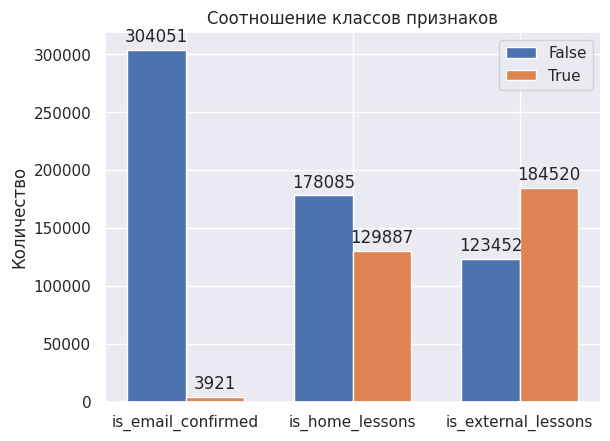

In [ ]:
labels = ['is_email_confirmed', 'is_home_lessons', 'is_external_lessons']
sizes_0 = [teachers_info['is_email_confirmed'].value_counts()[0],
           teachers_info['is_home_lessons'].value_counts()[0],
           teachers_info['is_external_lessons'].value_counts()[0]]
sizes_1 = [teachers_info['is_email_confirmed'].value_counts()[1],
           teachers_info['is_home_lessons'].value_counts()[1],
           teachers_info['is_external_lessons'].value_counts()[1]]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, sizes_0, width, label='False')
rects2 = ax.bar([val + width for val in x], sizes_1, width, label='True')

ax.set_ylabel('Количество')
ax.set_title('Соотношение классов признаков', size=12)
ax.set_xticks([val + width/2 for val in x])
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [ ]:
print(f"""описание lesson_duration:
{teachers_info['lesson_duration'].describe()}""")

print(f"""часть данных с некорректным значением признака:
{(1 - teachers_info[teachers_info['lesson_duration'] == 60]['id'].count() /
  teachers_info['id'].count()) * 100:.0f}%""")

описание lesson_duration:
count    307972.000000
mean         61.502978
std          15.061675
min           1.000000
25%          60.000000
50%          60.000000
75%          60.000000
max         999.000000
Name: lesson_duration, dtype: float64
часть данных с некорректным значением признака:
20%


In [ ]:
print(f"""описание lesson_cost:
{teachers_info['lesson_cost'].describe()}""")

print(f"""часть данных с некорректным значением признака:
{(1 - teachers_info[teachers_info['lesson_cost'] == 500]['id'].count() /
  teachers_info['id'].count()) * 100:.0f}%""")

описание lesson_cost:
count    3.079720e+05
mean     5.325806e+02
std      2.146357e+03
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+02
75%      9.000000e+02
max      1.021709e+06
Name: lesson_cost, dtype: float64
часть данных с некорректным значением признака:
91%


уникальные значения status_id:
7      5973
5    218439
4      9404
3     18904
2      2649
1     52603
Name: status_id, dtype: int64


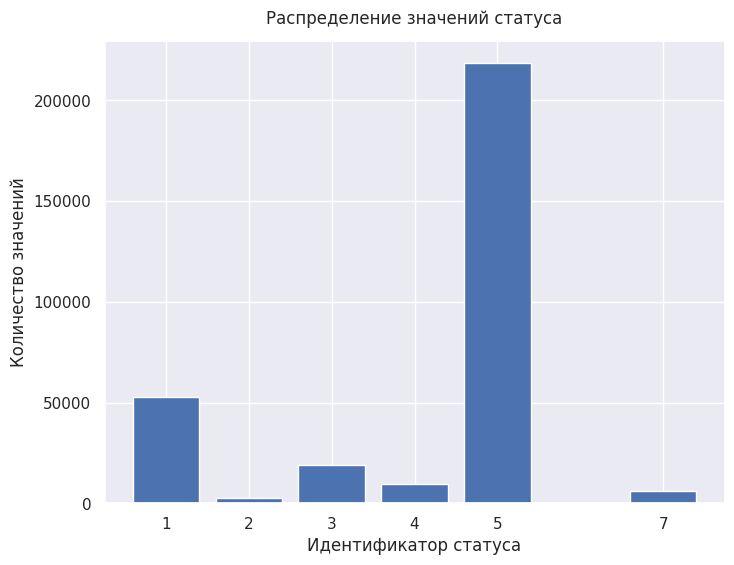

In [ ]:
print(f"""уникальные значения status_id:
{teachers_info['status_id'].value_counts().sort_index(ascending=False)}""")

plt.figure(figsize=(8, 6))
plt.bar(teachers_info['status_id'].value_counts().sort_values(ascending=True).index.tolist(),
        teachers_info['status_id'].value_counts().sort_values(ascending=True).tolist())

plt.xlabel('Идентификатор статуса')
plt.xticks(teachers_info['status_id'].value_counts().sort_index(ascending=True).index.tolist())
plt.ylabel('Количество значений')
plt.title('Распределение значений статуса', fontsize=12, y=1.02)
plt.show()

In [ ]:
print(f"""уникальные значения status_relevant_date:
{teachers_info['status_relevant_date'].value_counts().sort_index(ascending=False)}""")

уникальные значения status_relevant_date:
9900-09-01 00:00:00.000      6
9000-11-01 00:00:00.000      1
9000-09-01 00:00:00.000     74
9000-06-01 00:00:00.000      1
6135-05-01 00:00:00.000      1
                          ... 
2004-10-01 00:00:00.000      1
2000-11-01 00:00:00.000      1
2000-07-01 00:00:00.000      1
2000-06-01 00:00:00.000    115
2000-02-01 00:00:00.000      1
Name: status_relevant_date, Length: 1575, dtype: int64


In [ ]:
print(f"""уникальные значения status_school_id:
{teachers_info['status_school_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения status_school_id:
8068.0       1
8064.0       5
8060.0       3
8056.0       3
8052.0       1
          ... 
5.0         97
4.0         20
3.0       1503
2.0         23
1.0          3
Name: status_school_id, Length: 3595, dtype: int64


In [ ]:
print(f"""уникальные значения status_college_id:
{teachers_info['status_college_id'].value_counts().sort_index(ascending=False)}""")

уникальные значения status_college_id:
3100.0    1
3088.0    1
3082.0    2
3032.0    1
3024.0    1
         ..
12.0      1
6.0       7
5.0       9
4.0       4
3.0       3
Name: status_college_id, Length: 851, dtype: int64


уникальные значения status_display:
1    167455
0    140517
Name: status_display, dtype: int64


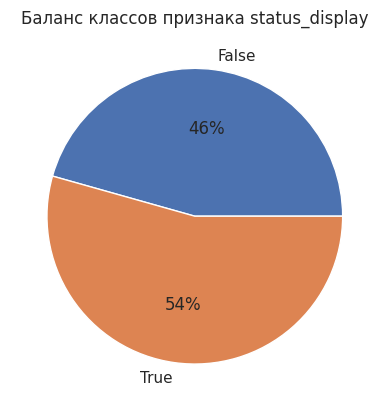

In [ ]:
print(f"""уникальные значения status_display:
{teachers_info['status_display'].value_counts().sort_index(ascending=False)}""")

labels = 'False', 'True'
sizes = [teachers_info['status_display'].value_counts()[0],
         teachers_info['status_display'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Баланс классов признака status_display', size=12)
plt.show()

уникальные значения russian_level_id:
5    259553
4       239
3       185
2      1828
1      2662
0     43505
Name: russian_level_id, dtype: int64


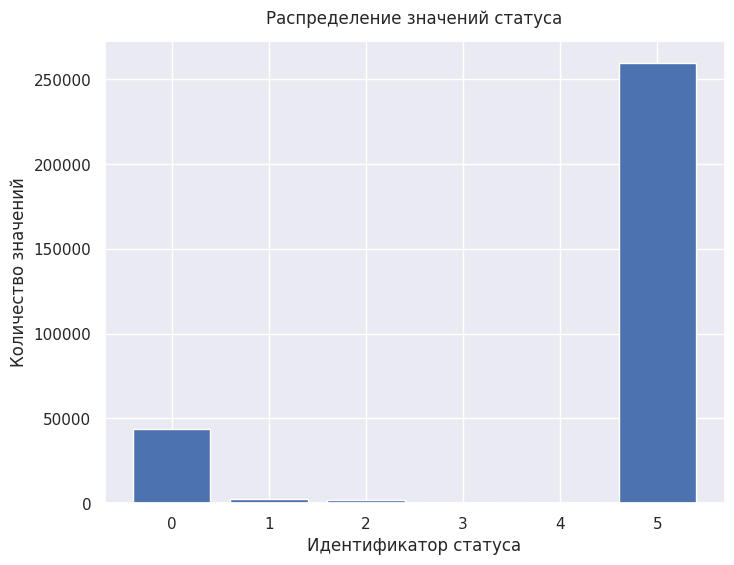

In [ ]:
print(f"""уникальные значения russian_level_id:
{teachers_info['russian_level_id'].value_counts().sort_index(ascending=False)}""")

plt.figure(figsize=(8, 6))
plt.bar(teachers_info['russian_level_id'].value_counts().sort_values(ascending=True).index.tolist(),
        teachers_info['russian_level_id'].value_counts().sort_values(ascending=True).tolist())

plt.xlabel('Идентификатор статуса')
plt.xticks(teachers_info['russian_level_id'].value_counts().sort_index(ascending=True).index.tolist())
plt.ylabel('Количество значений')
plt.title('Распределение значений статуса', fontsize=12, y=1.02)
plt.show()

In [ ]:
print(f"""количество уникальных значений home_country_id:
{teachers_info['home_country_id'].nunique()}""")

количество уникальных значений home_country_id:
147


In [ ]:
print(f"примеры записей в колонке add_info:\n{teachers_info['information'].unique()[:10]}")

примеры записей в колонке add_info:
['[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 К..., NaN, '[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учен..., '4 года репетиторской деятельности, \r\nподгот..., '[p]Кандидат биологических наук. Окончила музы..., 'Член Союза писателей России.', 'Аспирантура РГГУ (год окончания - 2011).\nРеп..., 'Методист-учитель.', 'Квалифицированный педагог.\nОпыт преподавания..., 'Marina Filipenko, professeur du russe langue ...]
Categories (121897, object): ['\tНоситель языка', '\n', '\n\n', '\n\n ', ...,
                              '•\tПобедитель республиканских олимпиад по мат...,
                              '•\tПреподавание студентам институтов  с 1 по ...,
                              '•\tимею публикации по проблемам дополнительно...,
                              '•2005-2006 гг. - курсы редких языков в МГИМО ...]


Столбцы абсолютно идентичны


id                          False
date_update                 False
reg_date                    False
birth_date                  False
teaching_start_date         False
                            ...  
review_num                  False
relevance_date              False
is_display_at_partners      False
status_institution_id       False
free_time_relevance_date    False
Length: 80, dtype: bool


In [ ]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

In [ ]:
teachers_info.drop(['date_update',
                    'reg_date',
                    'birth_date',
                    'teeching_start_date',
                    'user_id',
                    'external_comments',
                    'lesson_duration',
                    'lesson_cost',
                    'status_relevant_date',
                    'status_school_id',
                    'status_college_id',
                    'status_relevant_date',
                    'information'],
                   inplace=True
                   axis=1)
teachers_info.reset_index(drop=True, inplace=True)

#### Выводы и наблюдения
- полных дубликатов строк не обнаружено;
- количество полных дубликатов столбцов - 36. Из датафрейма их удаляю;
- в признаках `lesson_duration`, `lesson_cost` большой процент выбросов, данный признаки исключаю из дальнейшего исследования;
- в признаке `status_id` 6 уникальных значений, распределение по ним не равномерное;
- в признаке `russian_level_id` 6 уникальных значений, распределение по ним не равномерное;
- `information` данные записаны в неудобном формате. Принимаю решение их исключить;


### Подходящие по фильтру репетиторы

In [ ]:
suitable_teachers.info()
suitable_teachers.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
7951303,197612,2494147,NaN,0,0
3879323,199354,2137750,о,0,0
2205245,222853,1971779,.,0,0


In [ ]:
print(f"количество полных дубликатов строк: {suitable_teachers.duplicated().sum()}")
print(f"""количество полных дубликатов в общем количестве строк:
{suitable_teachers.duplicated().sum() / suitable_teachers.shape[0] * 100:.4f}%""")

количество полных дубликатов строк: 49
количество полных дубликатов в общем количестве строк:
0.0002%


Удаление обнаруженных повторов

In [ ]:
suitable_teachers.drop_duplicates(inplace=True)
suitable_teachers.reset_index(drop=True, inplace=True)

In [ ]:
print(f"""уникальные записи колонки contact_result:
{suitable_teachers['contact_result'].unique()}""")
print(f"""количество уникальных записей колонки contact_result:
{suitable_teachers['contact_result'].nunique()}""")

уникальные записи колонки contact_result:
['Репетитор согласился', 'Репетитор положил трубку, либо обрыв связи (O..., ',', NaN, 'Не дозвонились (Oktell)', ..., 'Богородский', '23 екат', 'Репетитор согласился с дополнительными услови..., 'Репетитор согласился с дополнительными услови..., 'к ученику?']
Length: 10867
Categories (10866, object): ['\nРепетитор оставил запрос : ', '\nРепетитор оставил запрос : \nРепетитор оста...,
                             '\nРепетитор оставил запрос : Договорились о з..., '\nРепетитор оставил запрос : О занятии догово...,
                             ..., '№',
                             '№1 анкета понравилась, кл пока не хочет конта..., '№2 анкета не понравилась',
                             '№3 анкета отправлена,  кл еще не смотрела']
количество уникальных записей колонки contact_result:
10866


In [ ]:
print(f"""уникальные значения enable_auto_assign:
{suitable_teachers['enable_auto_assign']
 .value_counts().sort_index(ascending=False)}""")

print(f"""уникальные значения enable_assign:
{suitable_teachers['enable_assign']
 .value_counts().sort_index(ascending=False)}""")

уникальные значения enable_auto_assign:
1     2617173
0    17653964
Name: enable_auto_assign, dtype: int64
уникальные значения enable_assign:
1      558434
0    19712703
Name: enable_assign, dtype: int64


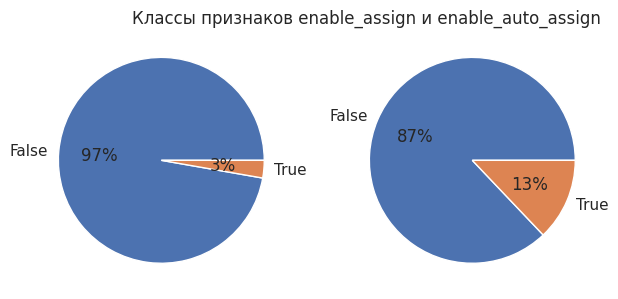

In [ ]:
labels = [False, True]
sizes_ea = [suitable_teachers['enable_assign'].value_counts()[0],
            suitable_teachers['enable_assign'].value_counts()[1]]
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.pie(sizes_ea, labels=labels, autopct='%1.0f%%')

sizes_eaa = [suitable_teachers['enable_auto_assign'].value_counts()[0],
             suitable_teachers['enable_auto_assign'].value_counts()[1]]
ax2.pie(sizes_eaa, labels=labels, autopct='%1.0f%%')

plt.title('Классы признаков enable_assign и enable_auto_assign', size=12, loc='right')
plt.tight_layout()
plt.show()

#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.0002% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности
- к категориальным признакам относятся: enable_auto_assign и enable_assign
- в признаке contact_result внесена информация в произвольном формате,
  <br>имеются совсем неинформативные записи ('23 екат', '...')

### Желаемые репетиторы (которых выбрал клиент)

In [ ]:
prefered_teachers_order_id.info()
prefered_teachers_order_id.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


,order_id,teacher_id
198577,1760293,38193
219191,2191747,81008
1089470,2388892,203361


In [ ]:
print(f"""количество полных дубликатов строк:
{prefered_teachers_order_id.duplicated().sum()}""")
print(f"""количество полных дубликатов в общем количестве строк:
{prefered_teachers_order_id.duplicated().sum() /
 prefered_teachers_order_id.shape[0] * 100:.3f}%""")

количество полных дубликатов строк:
16
количество полных дубликатов в общем количестве строк:
0.001%


Удаление обнаруженных повторов

In [ ]:
prefered_teachers_order_id.drop_duplicates(inplace=True)
prefered_teachers_order_id.reset_index(drop=True, inplace=True)

#### Выводы и наблюдения
- в таблице обнаружены дубликаты строк (0.001% от общего количества данных)
- принято решение об удалении найденных повторов ввиду их малочисленности

## Подготовка данных

### Объединение таблиц

In [ ]:
df = (orders_processed
      .merge(suitable_teachers[['teacher_id', 'order_id']],
             how='left',
             left_on=['id', 'working_teacher_id'],
             right_on=['order_id', 'teacher_id'])
      .drop_duplicates()
      .reset_index(drop=True)
      .merge(prefered_teachers_order_id,
             how='left',
             left_on=['id', 'working_teacher_id'],
             right_on=['order_id', 'teacher_id'])
      .drop_duplicates()
      .reset_index(drop=True)
      )

Создание признака `right_teacher`

In [ ]:
df['right_teacher'] = (np.where((df['working_teacher_id'] == df['teacher_id_x']) &
 (df['working_teacher_id'] == df['teacher_id_y']), 1, 0)
.astype('int8')
)

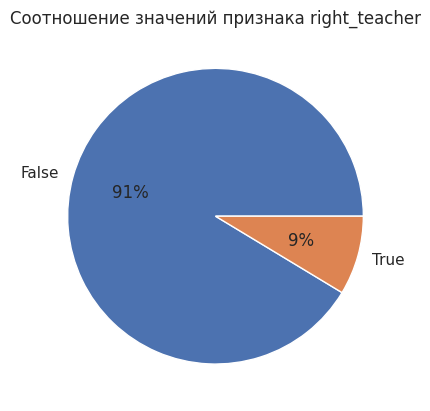

In [ ]:
labels = 'False', 'True'
sizes = [df['right_teacher'].value_counts()[0],
         df['right_teacher'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение значений признака right_teacher', size=12)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608083 entries, 0 to 608082
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       608083 non-null  int32  
 1   subject_id               608083 non-null  float32
 2   purpose                  608083 non-null  object 
 3   lesson_duration          608083 non-null  int32  
 4   home_metro_id            608083 non-null  float32
 5   working_teacher_id       406283 non-null  float32
 6   amount_to_pay            608083 non-null  float32
 7   planned_lesson_number    608083 non-null  int8   
 8   pupil_category_new_id    608083 non-null  int8   
 9   lessons_per_week         608083 non-null  int8   
 10  minimal_price            608083 non-null  int32  
 11  teacher_sex              608083 non-null  int8   
 12  teacher_experience_from  608083 non-null  int8   
 13  teacher_experience_to    608083 non-null  int8   
 14  less

Удаление временных признаков

In [ ]:
df = df.drop(['working_teacher_id',
             'teacher_id_x',
             'order_id_x',
             'order_id_y',
             'teacher_id_y'], axis=1)

Анализ корреляционных связей в конечных данных

interval columns not set, guessing: ['subject_id', 'lesson_duration', 'home_metro_id', 'amount_to_pay', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'source_id', 'fact_of_payment', 'order_month', 'lesson_price_cat', 'right_teacher']


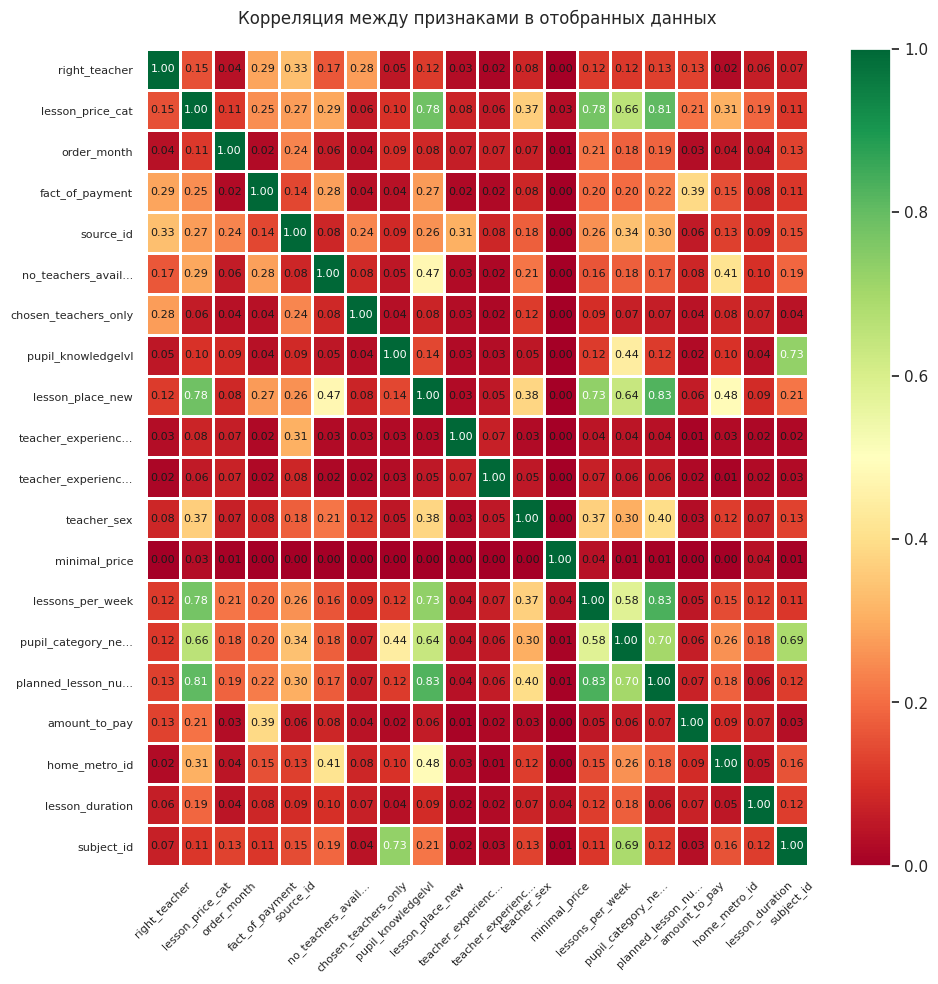

In [ ]:
phik_overview_fin = df.drop(columns=['id', 'purpose']).phik_matrix()

sns.set()
plot_correlation_matrix(phik_overview_fin.values,
                        x_labels=phik_overview_fin.columns,
                        y_labels=phik_overview_fin.index,
                        vmin=0, vmax=1,
                        fontsize_factor=0.8, figsize=(10, 10))
plt.xticks(rotation=45)
plt.title('Корреляция между признаками в отобранных данных', fontsize=12, y=1.02)
plt.tight_layout()

#### Выводы и наблюдения
- к таблице `orders` добавлены две другие таблицы по общоим колонкам: `order_id` и `teacher_id`
- добавлен категориальный признак `right_teacher`
- из окончательной таблицы удалены лишние признаки
- анализ матрицы корреляций окончательных признаков указывает:
  - линейных связей с целевым признаком у других признаков не наблюдается;
  - есть прямые зависимости между признаками lesson_price_cat, planned_lesson_number, lessons_per_week, lesson_place_new

### Масштабирование и кодирование данных

Кодирование текстов при помощи Sentence Transformer

In [ ]:
minilm = SentenceTransformer('all-MiniLM-L6-v2', device=device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# embeddings = minilm.encode(df['purpose'].values, device=device)
# embeddings.shape

Сохранение эмбеддингов в файл

In [ ]:
# with open('embeddings.pkl', 'wb') as f:
#     pickle.dump(embeddings, f)

Загрузка эмбеддингов из файла

In [ ]:
try:
  with open('data/embeddings.pkl', 'rb') as f:
    loaded_embeddings = pickle.load(f)
except:
  with open(userdata.get('embeddings'), 'rb') as f:
    loaded_embeddings = pickle.load(f)
loaded_embeddings.shape

(608083, 384)

Соединение эмбеддингов с остальными признаками

In [ ]:
try:
  compressed_embeddings = np.mean(embeddings, axis=1)
except:
  compressed_embeddings = np.mean(loaded_embeddings, axis=1)
compressed_embeddings.shape

(608083,)

In [ ]:
df['purpose_emb'] = compressed_embeddings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608083 entries, 0 to 608082
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       608083 non-null  int32  
 1   subject_id               608083 non-null  float32
 2   purpose                  608083 non-null  object 
 3   lesson_duration          608083 non-null  int32  
 4   home_metro_id            608083 non-null  float32
 5   amount_to_pay            608083 non-null  float32
 6   planned_lesson_number    608083 non-null  int8   
 7   pupil_category_new_id    608083 non-null  int8   
 8   lessons_per_week         608083 non-null  int8   
 9   minimal_price            608083 non-null  int32  
 10  teacher_sex              608083 non-null  int8   
 11  teacher_experience_from  608083 non-null  int8   
 12  teacher_experience_to    608083 non-null  int8   
 13  lesson_place_new         608083 non-null  int32  
 14  pupi

Pipeline подготовки выборок

In [ ]:
def data_preparation(data):
  '''
  - на вход получает датасет
  - производит отделение целевого признака,
    масштабирование данных,
    разделение на три выборки
  - на выходе: три выборки,
    печать размерностей этих выборок
  '''
  order_id = data['id']
  y = data['fact_of_payment']
  X = data.drop(['id', 'fact_of_payment'], axis=1)

  # Приведение данных к единому масштабу
  scaler = StandardScaler()
  X_es = (
      pd.DataFrame(scaler.fit_transform(X.drop(['purpose'], axis=1)),
                   columns=X.drop(['purpose'], axis=1).columns,
                   index=X.drop(['purpose'], axis=1).index)
      .merge(X['purpose'],
             how='left',
             left_index=True,
             right_index=True,
             sort=False)
      )
  # Разделение данных на выборки
  X_train, X_test, y_train, y_test = (train_test_split(X_es,
                                                       y,
                                                       test_size=0.1,
                                                       random_state=RANDOM_STATE,
                                                       stratify=y)
  )
  X_train, X_valid, y_train, y_valid = (train_test_split(X_train,
                                                         y_train,
                                                         test_size=0.2,
                                                         random_state=RANDOM_STATE,
                                                         stratify=y_train)
  )
  print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

  return X_train, X_valid, X_test, y_train, y_valid, y_test

Преобразование данных

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = data_preparation(df)

(437819, 21) (109455, 21) (60809, 21) (437819,) (109455,) (60809,)


#### Выводы и наблюдения
- из данных вынесены целевой и текстовый признаки;
- произведено масштабирование числовых данных и кодирование текстовых;
- произведено разделение на обучающую, валидационную и тестовую выборки.

## Обучение моделей

Pipeline обучения и получения метрик

In [ ]:
def modeling_pipeline(model_name, X_train, y_train, X_valid, y_valid):
  '''
  - на вход получает название модели, обучающие и валидационные данные;
  - на выходе строит ROC-кривую, выводит на печать значения метрик
  '''
  if model_name == 'Baseline':
    model = LogisticRegression(random_state=RANDOM_STATE)
    model.fit(X_train.drop(['purpose'], axis=1).values, y_train)
    y_pred_proba = model.predict_proba(X_valid.drop(['purpose'], axis=1).values)[:, 1]
    y_pred = model.predict(X_valid.drop(['purpose'], axis=1).values)

  elif model_name == 'CatBoost':
    model = CatBoostClassifier(random_state=RANDOM_STATE,
                               text_features=['purpose'],
                               eval_metric='AUC')
    model.fit(X_train.drop(['purpose_emb'], axis=1),
              y_train,
              eval_set=(X_valid.drop(['purpose_emb'], axis=1), y_valid),
              verbose=100)

    y_pred_proba = model.predict_proba(X_valid.drop(['purpose_emb'], axis=1))[:, 1]
    y_pred = model.predict(X_valid.drop(['purpose_emb'], axis=1).values)

  elif model_name == 'LightGBM':
    params = {"seed": RANDOM_STATE,
              "metric": ['auc', 'precision'],
              "verbosity": 1,
              "valid_sets": [lgb.Dataset(X_valid, label=y_valid)],
              "gpu_device_id": -1,
              "plot": True
              }
    model = lgb.train(params,
                      train_set=lgb.Dataset(X_train.drop(['purpose'], axis=1),
                                            label=y_train))
    y_pred_proba = model.predict(X_valid.drop(['purpose'], axis=1))
    y_pred = (y_pred_proba > 0.5).astype(int)

  # Вычисление ROC-AUC, Precision и F1
  roc_auc_value = roc_auc_score(y_valid, y_pred_proba)
  precision = precision_score(y_valid, y_pred)
  f1 = f1_score(y_valid, y_pred)

  # Визуализация кривой ROC
  fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
  sns.set_style('darkgrid')
  plt.plot(fpr, tpr, linewidth=1.5, label='ROC-ROC curve (area = %0.2f)' % roc_auc_value)
  plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, label='random_classifier')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=11)
  plt.ylabel('True Positive Rate', fontsize=11)
  plt.title('%s Receiver Operating Characteristic' % model_name, fontsize=12)
  plt.legend(loc='lower right')
  plt.show()

  print(f"ROC-AUC на валидационной выборке: {round(roc_auc_value, 2)}")
  print(f"Precision на валидационной выборке: {round(precision, 2)}")
  print(f"F1 на валидационной выборке: {round(f1, 2)}")

  return roc_auc_value, precision, f1, model

### Baseline (Logistic Regression)

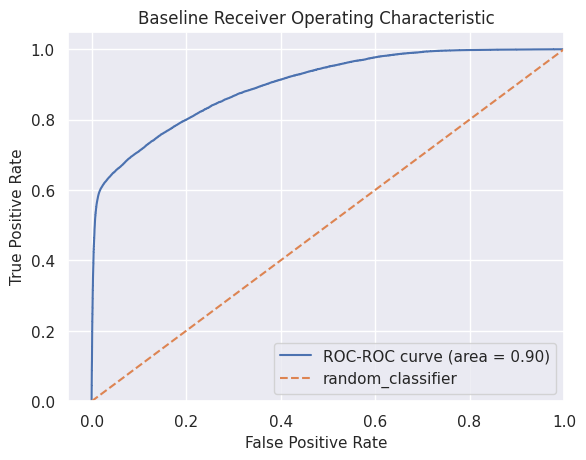

ROC-AUC на валидационной выборке: 0.9
Precision на валидационной выборке: 0.92
F1 на валидационной выборке: 0.71


In [ ]:
roc_auc_baseline, precision_baseline, f1_baseline, baseline = (
    modeling_pipeline('Baseline',
                      X_train,
                      y_train,
                      X_valid,
                      y_valid)
    )

### CatBoost

Learning rate set to 0.142334
0:	test: 0.8517459	best: 0.8517459 (0)	total: 1.66s	remaining: 27m 35s
100:	test: 0.9197692	best: 0.9197692 (100)	total: 1m 48s	remaining: 16m 8s
200:	test: 0.9211429	best: 0.9211429 (200)	total: 3m 31s	remaining: 13m 58s
300:	test: 0.9216760	best: 0.9216760 (300)	total: 5m 9s	remaining: 11m 59s
400:	test: 0.9219264	best: 0.9219264 (400)	total: 6m 43s	remaining: 10m 3s
500:	test: 0.9221089	best: 0.9221092 (498)	total: 8m 15s	remaining: 8m 13s
600:	test: 0.9223236	best: 0.9223236 (600)	total: 9m 47s	remaining: 6m 30s
700:	test: 0.9224528	best: 0.9224528 (700)	total: 11m 18s	remaining: 4m 49s
800:	test: 0.9224590	best: 0.9224741 (782)	total: 12m 48s	remaining: 3m 11s
900:	test: 0.9225264	best: 0.9225264 (900)	total: 14m 20s	remaining: 1m 34s
999:	test: 0.9225931	best: 0.9225940 (974)	total: 15m 56s	remaining: 0us

bestTest = 0.9225939847
bestIteration = 974

Shrink model to first 975 iterations.


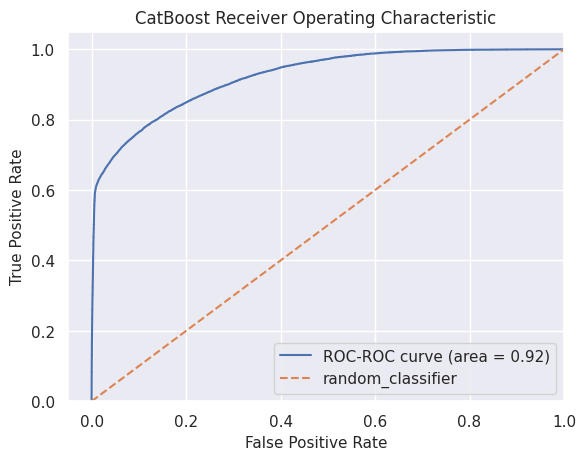

ROC-AUC на валидационной выборке: 0.92
Precision на валидационной выборке: 0.93
F1 на валидационной выборке: 0.74


In [ ]:
roc_auc_cb, precision_cb, f1_cb, cbst = (
    modeling_pipeline('CatBoost',
                      X_train,
                      y_train,
                      X_valid,
                      y_valid)
    )

### LightGBM

[LightGBM] [Warning] Unknown parameter: valid_sets
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x7cce6b519900>
[LightGBM] [Warning] Unknown parameter: plot
[LightGBM] [Warning] Unknown parameter: valid_sets
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x7ccd6d3e0fa0>
[LightGBM] [Warning] Unknown parameter: plot
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 437819, number of used features: 20
[LightGBM] [Info] Start training from score 0.205094


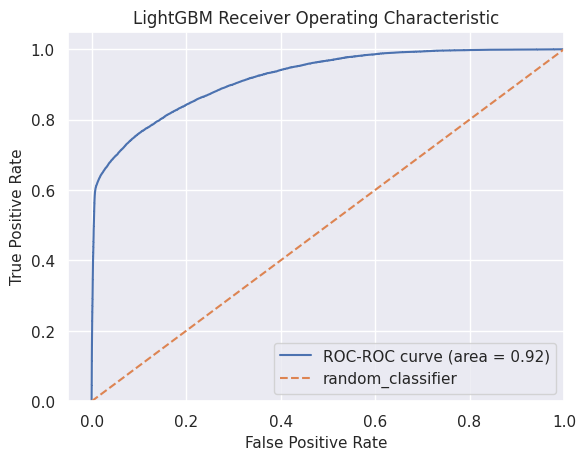

ROC-AUC на валидационной выборке: 0.92
Precision на валидационной выборке: 0.94
F1 на валидационной выборке: 0.74


In [ ]:
roc_auc_lgb, precision_lgb, f1_lgb, lgbm = (
    modeling_pipeline('LightGBM',
                      X_train,
                      y_train,
                      X_valid,
                      y_valid)
    )

## Выбор лучшей модели

In [ ]:
dict_sum = {'Baseline': [roc_auc_baseline, precision_baseline, f1_baseline],
            'Catboost': [roc_auc_cb, precision_cb, f1_cb],
            'LightGBM': [roc_auc_lgb, precision_lgb, f1_lgb]}
summary_data = (pd.DataFrame.from_dict(dict_sum, orient='index',
                                       columns=["roc-auc",
                                                "precision",
                                                "f1_score"])
                                       .reset_index()
                                       .rename(columns={'index': 'model'})
                                       )
summary_data.sort_values('roc-auc', ascending=False).reset_index(drop=True)

,model,roc-auc,precision,f1_score
0,Catboost,0.922594,0.931296,0.743651
1,LightGBM,0.919228,0.938478,0.742556
2,Baseline,0.899076,0.921752,0.707919


Проверка качества лучшей модели на тестовой выборке

In [ ]:
# Вычисление ROC-AUC
y_proba_test = cbst.predict_proba(X_test.drop(['purpose_emb'], axis=1))[:, 1]
roc_auc_test = roc_auc_score(y_test, y_proba_test)

# Вычисление precision и F1
y_pred_test = cbst.predict(X_test.drop(['purpose_emb'], axis=1).values)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"ROC-AUC на тестовой выборке: {round(roc_auc_test, 2)}")
print(f"Precision на тестовой выборке: {round(precision_test, 2)}")
print(f"F1 на тестовой выборке: {round(f1_test, 2)}")

ROC-AUC на тестовой выборке: 0.92
Precision на тестовой выборке: 0.93
F1 на тестовой выборке: 0.74


Визуализация матрицы ошибок

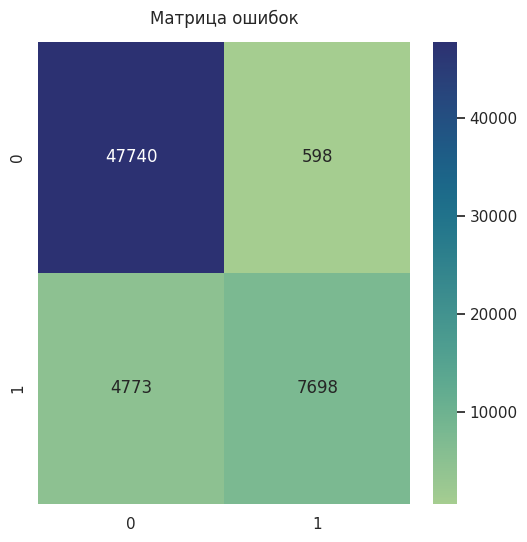

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test.round()),
            annot=True,
            fmt='3.0f',
            cmap='crest')
plt.title('Матрица ошибок', fontsize=12, y=1.02)
plt.show()

Выявление важности признаков

Встроенные средства

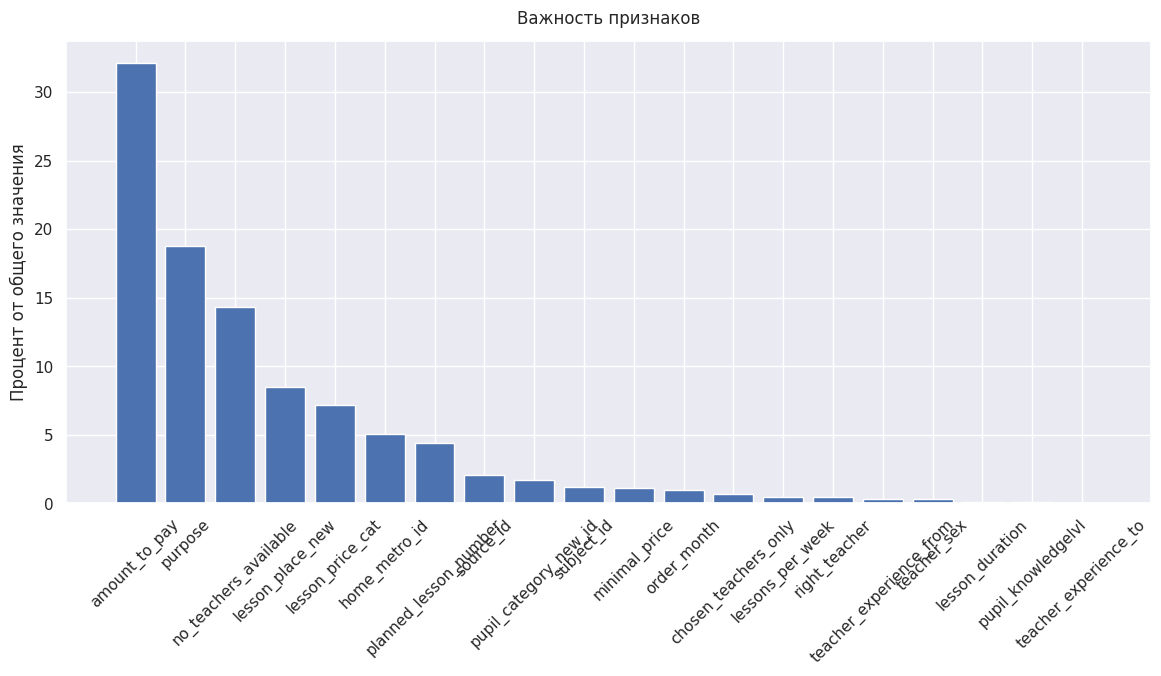

,feature,percent
0,amount_to_pay,32.1
1,purpose,18.8
2,no_teachers_available,14.3
3,lesson_place_new,8.5
4,lesson_price_cat,7.2


In [ ]:
features_importance = (
    pd.DataFrame(data = {'feature': X_train.drop(['purpose_emb'], axis=1).columns,
                         'percent': np.round(cbst.feature_importances_, decimals=1)})
)

plt.figure(figsize=(14, 6))
plt.bar(features_importance.sort_values('percent', ascending=False)['feature'],
        features_importance.sort_values('percent', ascending=False)['percent'])

plt.xticks(features_importance['feature'])
plt.xticks(rotation=45)
plt.ylabel('Процент от общего значения')
plt.title("Важность признаков", fontsize=12, y=1.02)
plt.show()

features_importance.sort_values('percent', ascending=False).reset_index(drop=True)[:5]

Библиотека shap

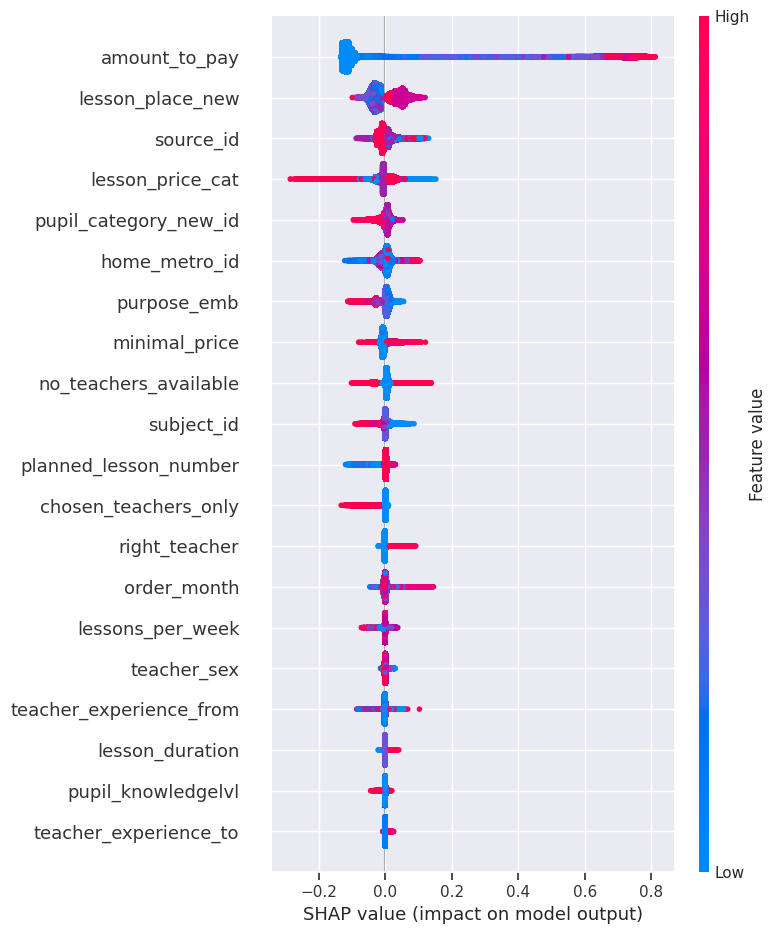

In [ ]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train.drop(['purpose'], axis=1))
shap.summary_plot(shap_values, X_train.drop(['purpose'], axis=1))

#### Выводы и наблюдения
- лучшие значения метрик при обучении показала модель `Catboost`:
  - `ROC-AUC = 0.922594`
  - `Precision =	0.931296`
- метрики при проверке на отложенной выборке:
  - `ROC-AUC = 0.92`
  - `Precision =	0.93`
- заключение по матрице ошибок:
  - модель с высоким качеством определяет класс 0,
  - при определении класса 1 высокий показатель ошибок;
- наиболее важными признаками для модели выявлены:
  - `amount_to_pay`
  - `purpose`

## Создание файла зависимостей

In [ ]:
# !pip install pipreqs
# !pipreqs /content --force

# !pip freeze > requirements.txt
# !pipreqsnb operator_performance_analytics.ipynb

## Заключение
Отчёт по выполненным в ходе исследования шагам.

### Загрузка и первичная обработка данных
1. Основной таблицей исследования принята таблица `orders`
  - из неё удалены явные повторы строк
  - обработаны дубликаты заявок
  - преобразованы типы данных по необходимости
  - созданы дополнительные признаки, в том числе и целевой
  - проанализирован каждый признак
  - заполнены пропущенные значения при небходимости
  - после всех преобразований в таблице осталось 22 признака, количество строк сократилось практически в два раза
2. Таблица с данными об учителях проанализирована на предмет дубликатов.
3. Остальные таблицы также проверены на дубликаты и пропуски.
4. По итогам данного шага составлен небольшой отчёт по преобразованиям и наблюдениям.

### Подготовка данных
1. Данные собраны в единый датафрейм с основной таблицей.
2. В нём создан дополнительный признак.
3. Изучены корреляционные связи признаков.
4. Произведено кодирование текстов в эмбеддинги.
5. Произведено масштабирование признаков.
6. Данные разделены на три выборки с учётом дисбаланса классов:
  - обучающую (72% от полного набора данных)
  - валидационную (18% от полного набора) данных
  - тестовую (10%)

### Обучение моделей
- Обучены три модели:
  - в качестве baseline использована логистическая регрессия
  - также использованы две модели градиентного бустинга: CatBoost, LightGBM
  - значения метрик на валидационной выборке

|model|roc-auc|precision|f1_score|
|---:|---:|---:|---:|
|Catboost|0.922594|0.931296|0.743651|
|LightGBM|0.919228|0.938478|0.742556|
|Baseline|0.899076|0.921752|0.707919|

- Лучший результат по ROC-AUC показала модель CatBoost

### Тестирование лучшей модели
- Проверка модели на тестовой выборке также показала удовлетворительные результаты: `ROC-AUC = 0.92`, `Precision = 0.93`
- Матрица ошибок указывает на то, что модель с высоким качеством определяет класс 0, при определении класса 1 высокий показатель ошибок;
- Наиболее важными признаками для модели выявлены: amount_to_pay, purpose, no_teachers_available

По итогам исследования можно сделать заключение, что наиболее подходящей моделью для решения поставленной задачи Заказчика является градиентный бустинг `CatBoost`